In [1]:
CIFAR_DIR = 'cifar-10-batches-py/'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [8]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
# Cde to transform the X array!
X = data_batch1[b"data"]
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
print(X.shape)

(10000, 32, 32, 3)


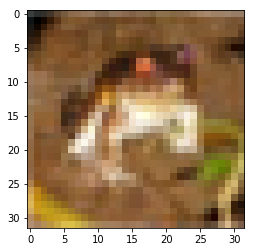

In [11]:
plt.imshow(X[0])

# Helper Functions for Dealing With Data.

** Use the provided code below to help with dealing with grabbing the next batch once you've gotten ready to create the Graph Session. Can you break down how it works? **

In [12]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [13]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

** How to use the above code: **

In [14]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model

** Import tensorflow **

In [15]:
import tensorflow as tf

/home/ashish/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ashish/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ashish/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ashish/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

** Create 2 placeholders, x and y_true. Their shapes should be: **

* x shape = [None,32,32,3]
* y_true shape = [None,10]


In [16]:
x = tf.placeholder(tf.float32, shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

** Create one more placeholder called hold_prob. No need for shape here. This placeholder will just hold a single probability for the dropout. **

In [17]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [18]:
# HELPER

# INIT WEIGHTS

def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init_random_dist)


# INIT BIAS

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)



# CONV2D

def conv2d(x,W):
    # x --> [batch, H, W, Channels]
    # W --> [filter H, filter W, Channels IN, Channels OUT]
    
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')



# POOLING

def max_pool_2by2(x):
    # x --> [batch,h,w,c]
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

# Convolutional Layer

def convolutional_layer(input_x,shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)
    

# Normal (Fully Connected Layer)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Create the Layers

** Create a convolutional layer and a pooling layer as we did for MNIST. **
** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [19]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [20]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

** Now create a flattened layer by reshaping the pooling layer into [-1,8 \* 8 \* 64] or [-1,4096] **

In [21]:
8*8*64

4096

In [22]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

** Create a new full layer using the normal_full_layer function and passing in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

In [23]:
full_layer_1 = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

** Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

In [24]:
# DROPOUT

hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_1, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


** Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. The size should be 10 because of the 10 possible labels**

In [25]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [26]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Optimizer

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

** Create a variable to intialize all the global tf variables. **

In [28]:
init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [30]:

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(200):
        
        batch = ch.next_batch(100)
        
        sess.run(train,feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%50 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x: ch.test_images,y_true: ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1


Currently on step 50
Accuracy is:
0.2527


Currently on step 100
Accuracy is:
0.3079


Currently on step 150
Accuracy is:
0.3368


